In [51]:
import numpy as np
import math
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor as rfr
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib import ticker
import datetime
import os
import sys
import re
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.nan)
sys.path.append('./')
sys.path.append('../')
sys.path.append('../../')
import futures_series as futs


Use reload if you make changes to futures_series.py

In [178]:
from importlib import reload
reload(futs)

<module 'futures_series' from '/Users/bperlman1/Documents/billybyte/pyliverisk/barchartapi/barchartapi/futures_series.py'>

Set up folders that have previous fetched csv files from barchart

In [149]:
DIR_MARKET_DATA = '/users/bperlman1/dropbox/market_data'
DIR_FUTURES = f'{DIR_MARKET_DATA}/futures'
DIR_CL = f'{DIR_FUTURES}/CL'
DIR_NG = f'{DIR_FUTURES}/NG'
DIR_HO = f'{DIR_FUTURES}/HO'
DIR_STOCKS = f'{DIR_MARKET_DATA}/stocks'
from tqdm import tqdm

point to the CL folder

In [54]:
files = os.listdir(f'{DIR_CL}')
print(files)

['.dropbox', '.DS_Store', 'CL_200801_200812.csv', 'CL_200901_201012.csv', 'CL_201101_201212.csv', 'CL_201301_201412.csv', 'CL_201501_201612.csv', 'CL_201701_201812.csv', 'Icon\r']


The loop below will combine all of the csv files for CL to a single pandas DataFrame

In [55]:
df = None
for f in tqdm(files):
    if len(re.findall('CL_20[0-3][0-9][0-1][0-9]_',f))<1:
        continue
    print(f'reading {f}')
    df_temp = pd.read_csv(f'{DIR_CL}/{f}')
    if df is None:
        df = df_temp.copy()
    else:
        df = df.append(df_temp)

  0%|          | 0/9 [00:00<?, ?it/s]

reading CL_200801_200812.csv


 33%|███▎      | 3/9 [00:00<00:00,  8.37it/s]

reading CL_200901_201012.csv


 44%|████▍     | 4/9 [00:01<00:01,  2.82it/s]

reading CL_201101_201212.csv


 56%|█████▌    | 5/9 [00:02<00:02,  1.90it/s]

reading CL_201301_201412.csv


 67%|██████▋   | 6/9 [00:04<00:02,  1.50it/s]

reading CL_201501_201612.csv


 78%|███████▊  | 7/9 [00:05<00:01,  1.31it/s]

reading CL_201701_201812.csv


100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


In [56]:
print(df.as_matrix().shape)
df.columns.values

(3814517, 8)


array(['close', 'high', 'low', 'open', 'symbol', 'timestamp',
       'tradingDay', 'volume'], dtype=object)

Add all of the columns that help analyze futures bar data

In [57]:
df2 = futs.proc_df(df)
print(df2.as_matrix().shape)
df2.columns.values

/Users/bperlman1/Documents/billybyte/pyliverisk/barchartapi/barchartapi/futures_series.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['yyyymmddhhmm'] = df.timestamp.apply(_yyyymmddhhmm)


(3814514, 19)


array(['cyear', 'cmonth', 'symbol', 'year', 'month', 'day', 'hour',
       'minute', 'tyear', 'tmonth', 'tday', 'yyyymmddhhmm', 'close',
       'high', 'low', 'open', 'volume', 'last_yyyymmddhhmm', 'dte'],
      dtype=object)

Make sure that there are no dte's (days to expiration) greater than 100

In [64]:
df2[df2.dte>100]

,cyear,cmonth,symbol,year,month,day,hour,minute,tyear,tmonth,tday,yyyymmddhhmm,close,high,low,open,volume,last_yyyymmddhhmm,dte


Create df2 dataframe, elliminating unnecessary columns that are not used in other aggregate analysis

In [59]:
scale_columns = list(futs.FuturesSeries.scale_functions.keys())
df2.dte.unique()

array([15, 14, 13, 12, 11,  8,  7,  6,  5,  4,  1,  0, 32, 31, 30, 29, 28,
       25, 24, 23, 22, 21, 18, 17, 16, 10,  9,  3,  2, 34, 33, 27, 26, 20,
       19])

use pivot_table to show trading days where there are 2 futures contracts in df2

In [177]:
# create pivot_table and use reset_index to make columns out of multi_index indices
dfp = df2[['tyear','tmonth','tday','symbol','volume']].pivot_table(values='volume',index=['tyear','tmonth','tday','symbol'],aggfunc='count').reset_index()
# get counts of symbols in history by trading date
dfgb = dfp[['tyear','tmonth','tday','symbol']].groupby(['tyear','tmonth','tday'],as_index=False).count()
# show the trading dates where there are 2 contracts in df2
dfgb[dfgb.symbol>1]


,tyear,tmonth,tday,symbol
10,2008,5,19,2
11,2008,5,20,2
32,2008,6,18,2
33,2008,6,19,2
34,2008,6,20,2
55,2008,7,21,2
56,2008,7,22,2
76,2008,8,19,2
77,2008,8,20,2
100,2008,9,18,2


Process a single month

In [61]:
sym=['CLM18']
df3 = df2[df2.symbol.isin(sym)]
len(df3)

32772

Show autocorrelation, partial autocorrelation and ARIMA plots on dummy sin data

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   89
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 659.170
Method:                       css-mle   S.D. of innovations              0.000
Date:                Tue, 18 Dec 2018   AIC                          -1304.341
Time:                        20:55:27   BIC                          -1286.920
Sample:                             1   HQIC                         -1297.319
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.511e-08        nan        nan        nan         nan         nan
ar.L1.D.y     -0.6817        nan        nan        nan         nan         nan
ar.L2.D.y      1.3650        nan        nan        n

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 &

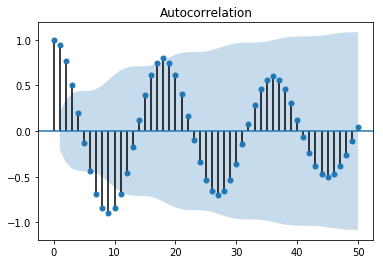

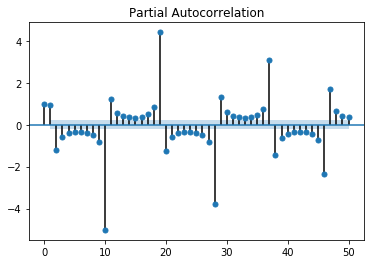

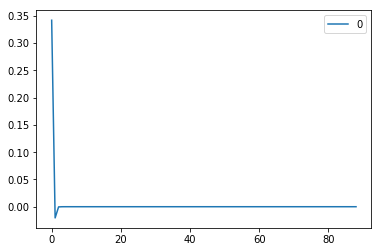

In [62]:
# generate a set of degrees
ev = 360*5
# generate a subset of ev
ev_subset = 20
xv = np.arange(0,ev,ev_subset)
# create y values with as much as you want
noise_factor = 0
yv = [math.sin(i/180*math.pi) + np.random.normal(loc=0,scale=1)*noise_factor for i in xv]
dfv = pd.DataFrame({'x':xv,'y':yv})
plot_acf(np.array(dfv.y),lags=50)
plot_pacf(np.array(dfv.y),lags=50)

model = ARIMA(np.array(dfv.y),order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
# dfv.plot.bar(x='x',y='y',figsize=(12,10))

Show Plots of absolute changes for the contact month in df3. 
Specify first_hour and last_hour

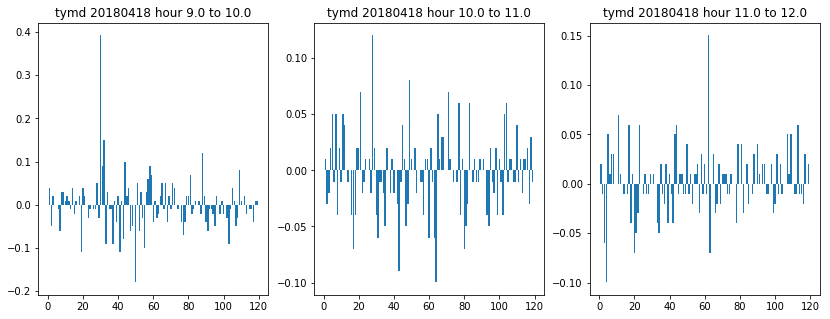

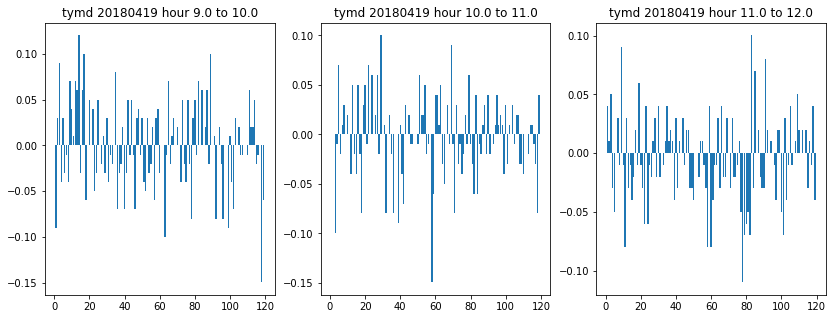

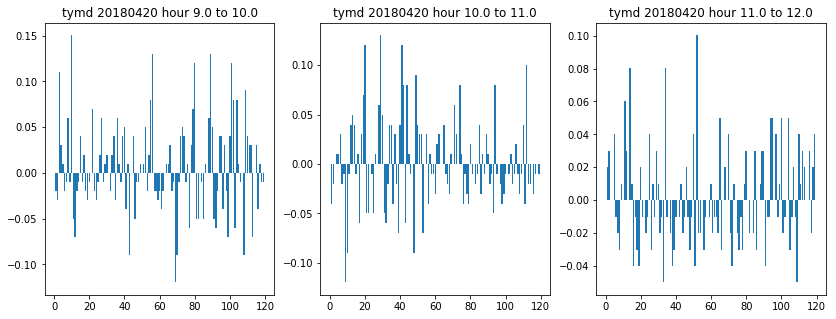

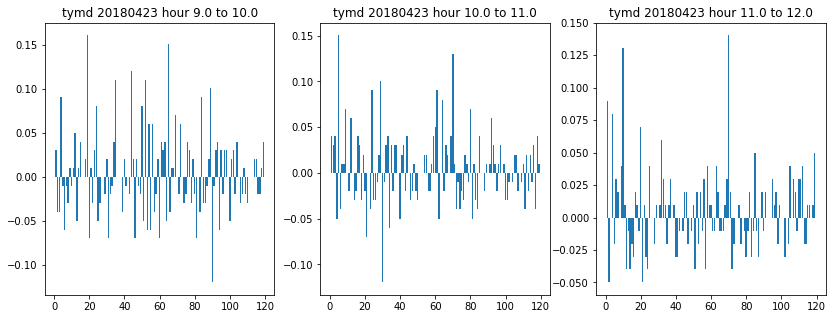

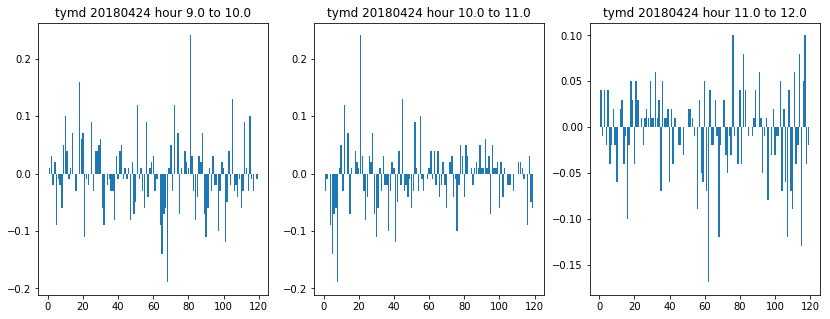

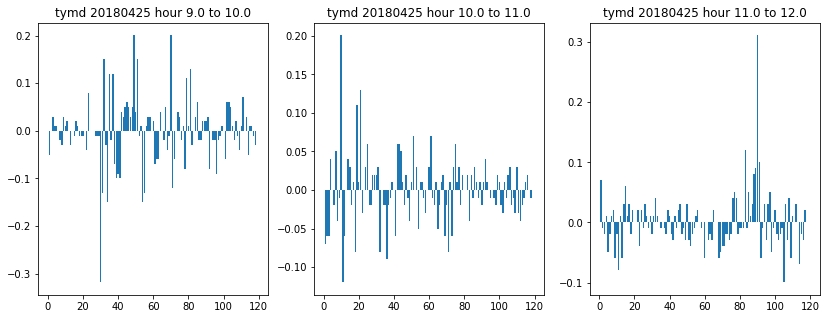

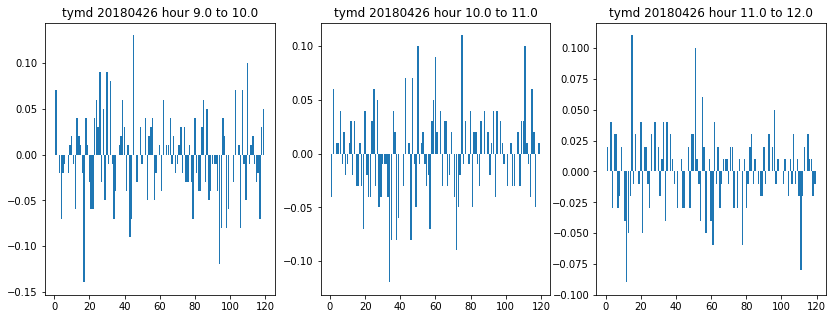

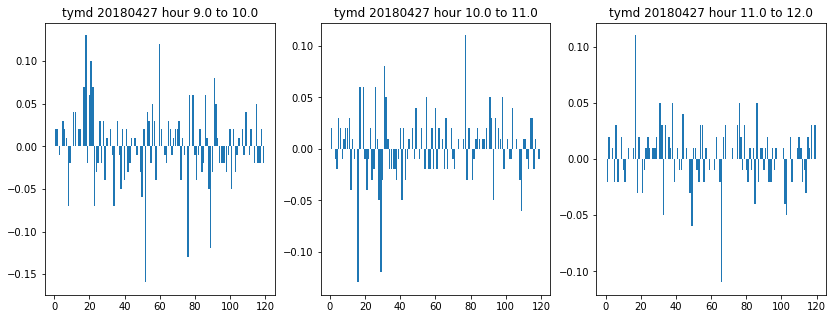

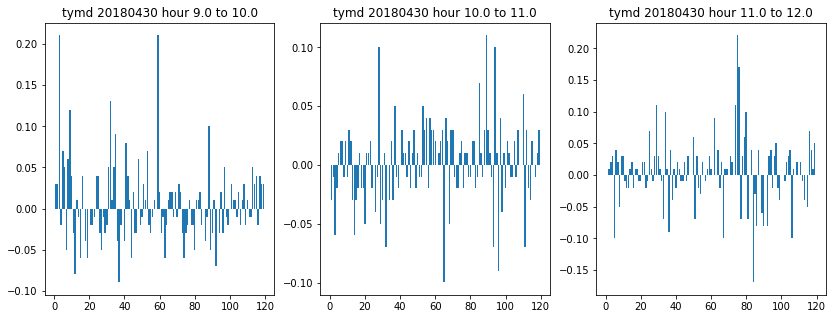

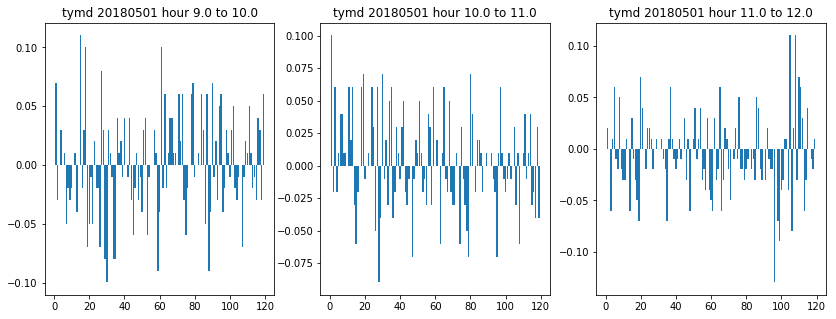

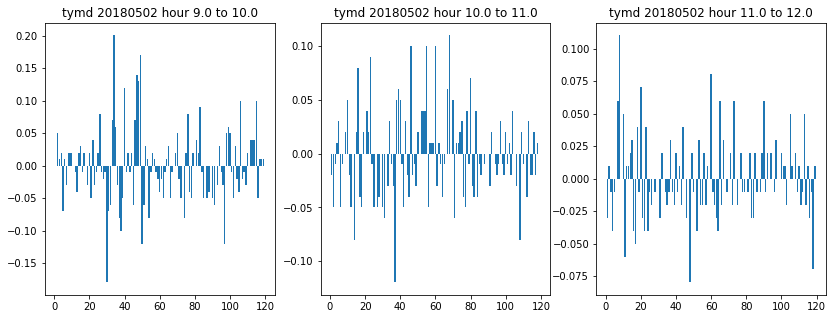

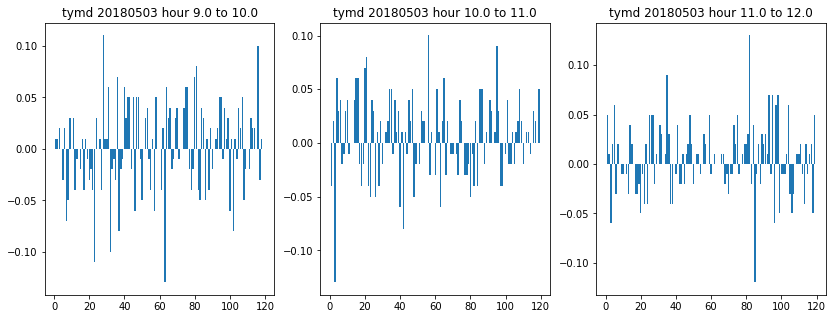

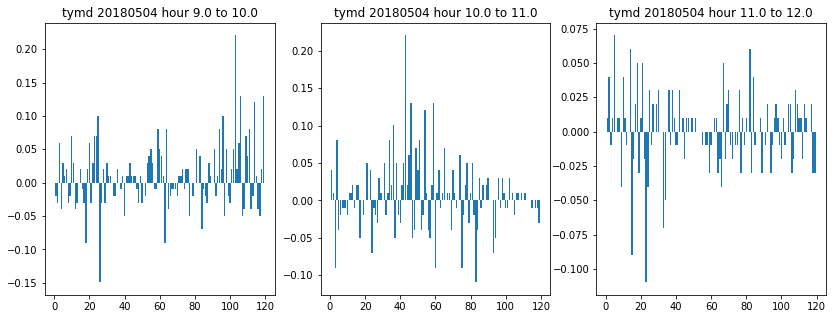

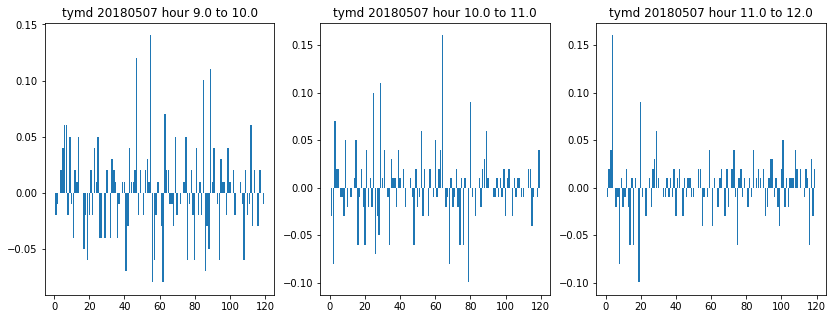

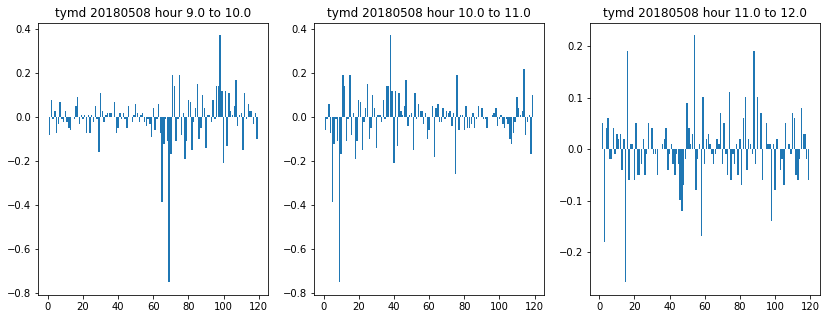

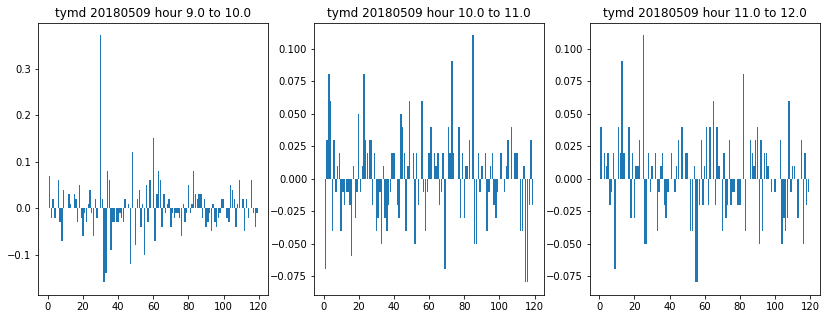

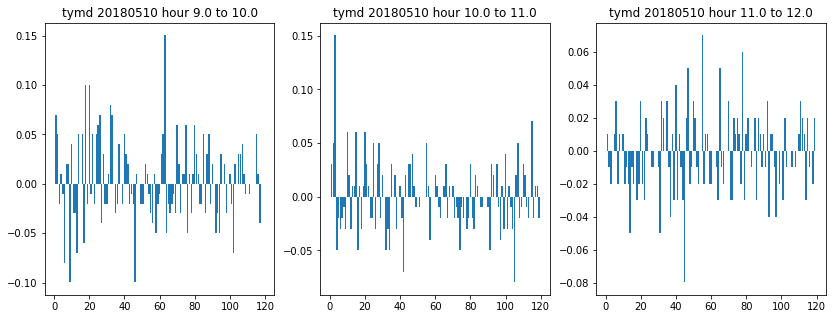

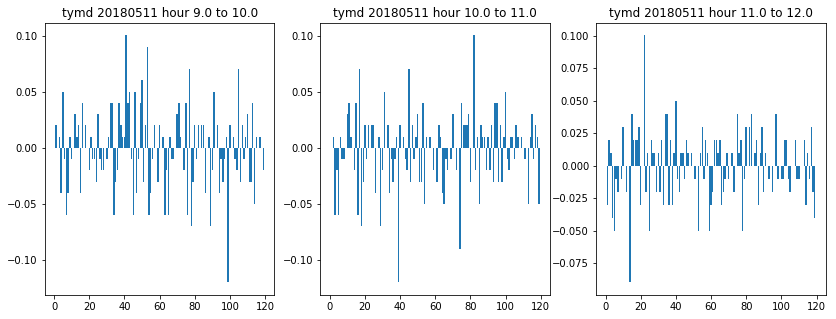

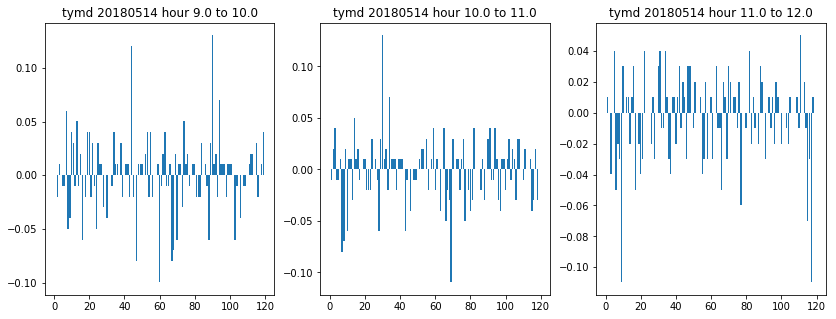

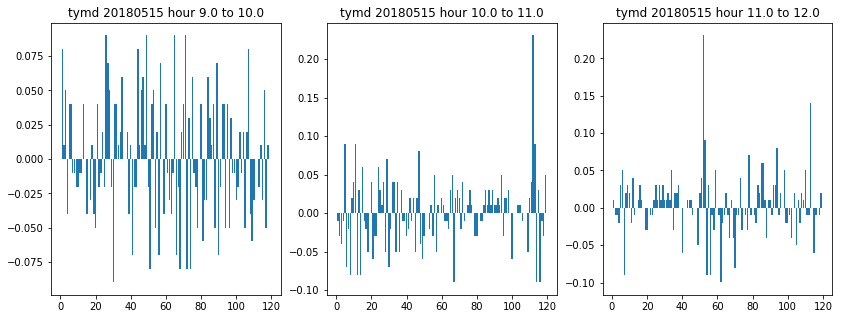

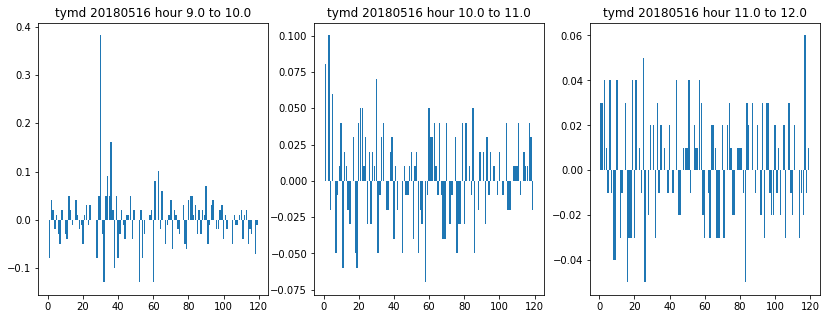

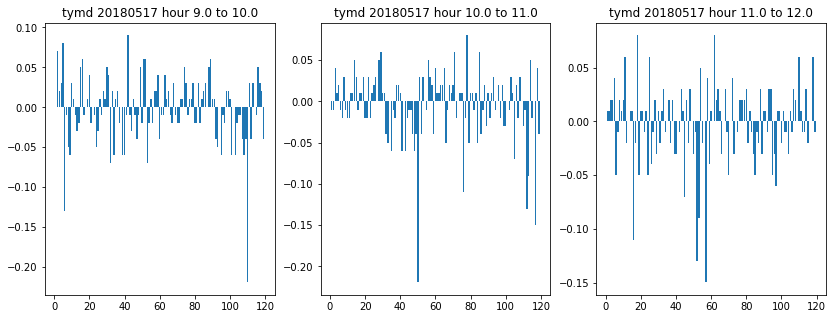

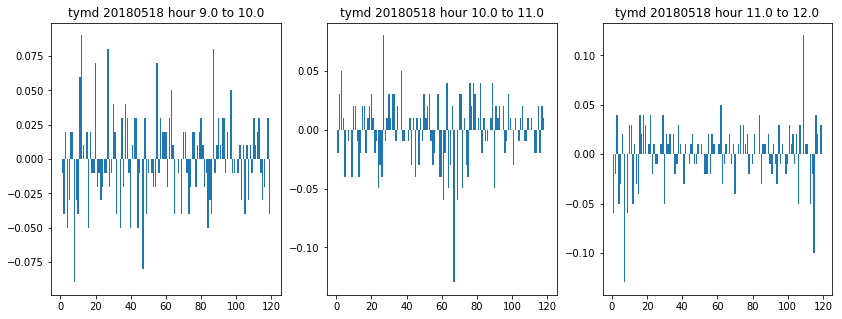

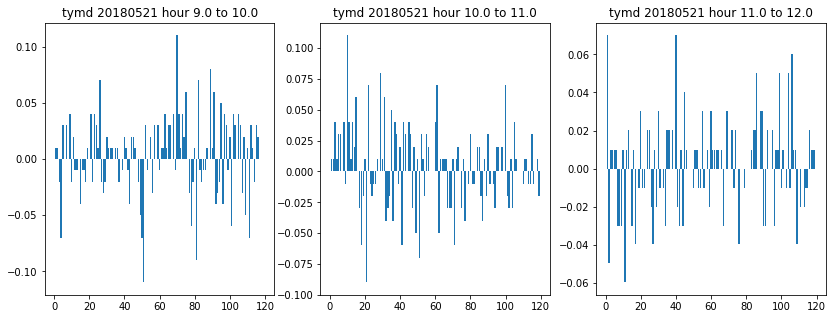

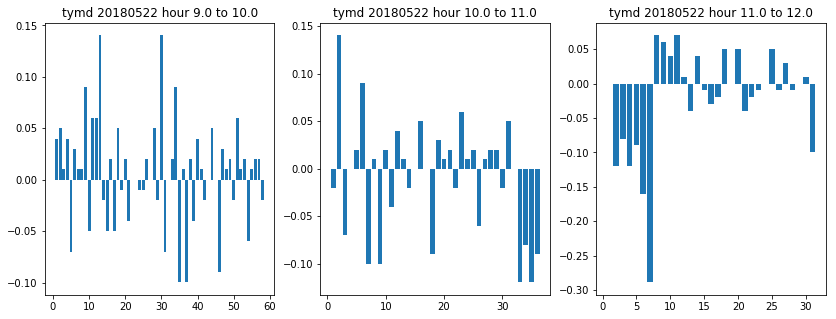

In [88]:
# change these
first_hour=9
last_hour=11

num_graphs_per_row = last_hour - first_hour + 1
tymds = df3.apply(lambda r: int('%04d%02d%02d' %(r.tyear,r.tmonth,r.tday)),axis=1).unique()
for tymd in tymds:
    y = int(str(tymd)[0:4])
    m = int(str(tymd)[4:6])
    d = int(str(tymd)[6:8])
    df_1d = df3[(df3.tyear==y) & (df3.tmonth==m)&(df3.tday==d)]
    total_plots= last_hour - first_hour + 1
    plt.figure(1,figsize=(14,5*(total_plots//2)))
    for i in np.linspace(first_hour,last_hour,total_plots):
        plot_num = i-first_hour + 1
        plt.subplot(total_plots//num_graphs_per_row,num_graphs_per_row,plot_num,title=f'tymd {tymd} hour {i} to {i+1}')
        df_1d2 = df_1d[(df_1d.hour>=i) & (df_1d.hour<=i+1)]
        xv = np.array(range(len(df_1d2)))
        pc = np.array(df_1d2.close.pct_change()*df_1d2.close)
        plt.bar(xv,pc)
    plt.show()

Show autocorrelation plot

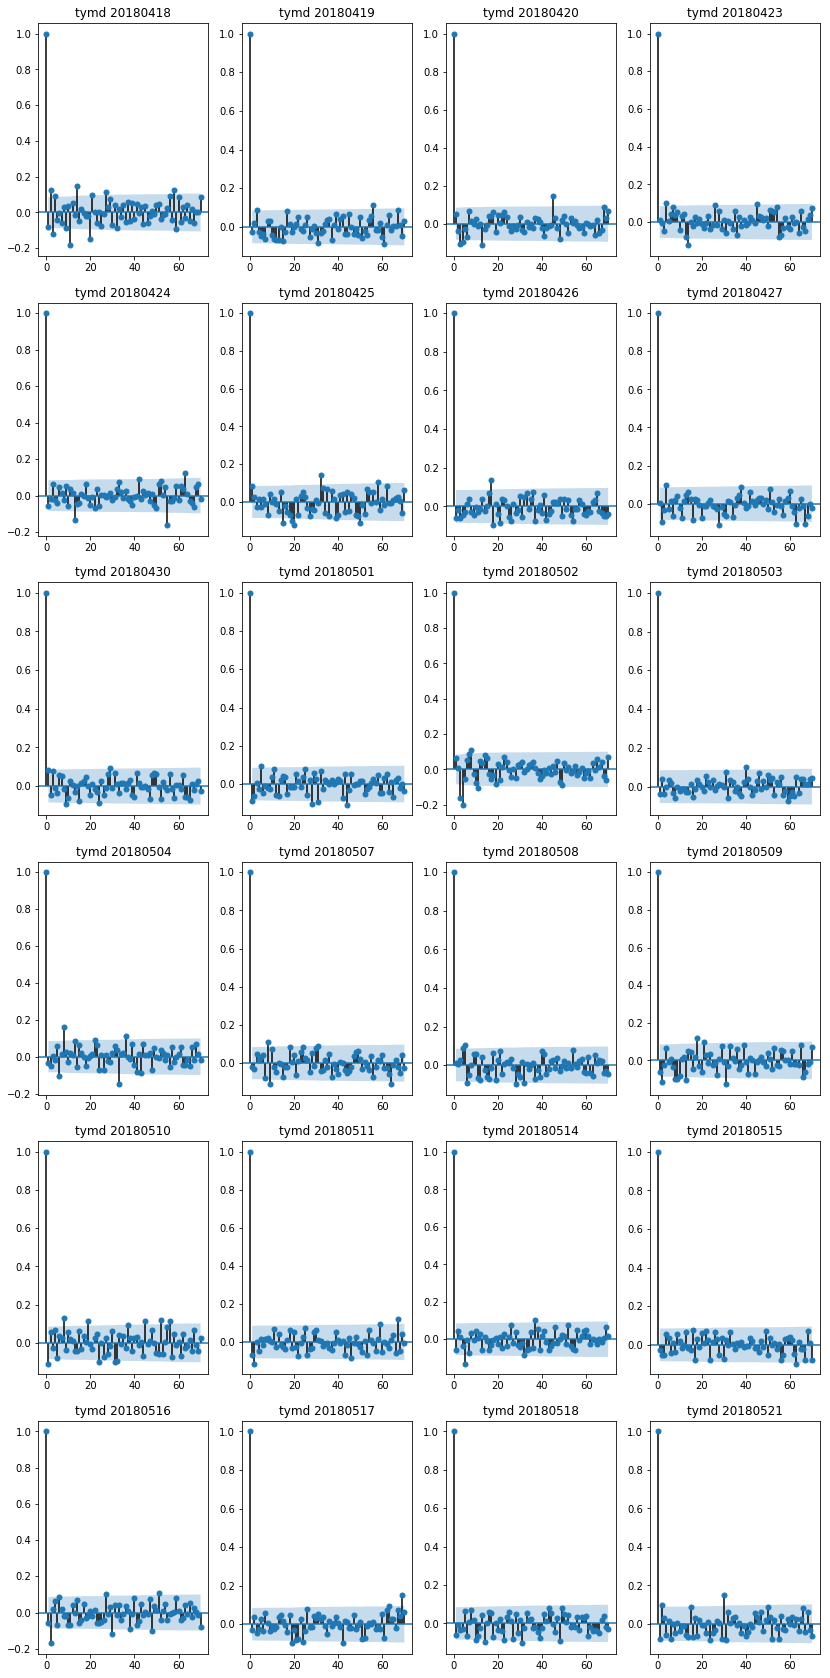

In [134]:
# change these
contract='CLM18'
start_hour=7
end_hour=17
num_graphs_per_row = 4
df3 = df2[df2.symbol==contract]
tymds = df3.apply(lambda r: int('%04d%02d%02d' %(r.tyear,r.tmonth,r.tday)),axis=1).unique()
total_plots= len(tymds)
even_num_tymds = len(tymds)//num_graphs_per_row * num_graphs_per_row
tymds_even_sets = np.array(tymds)[:even_num_tymds]
tymd_sets = np.array(tymds_even_sets).reshape(-1,num_graphs_per_row)
total_figure_length = total_plots//num_graphs_per_row
# plt.figure(1,figsize=(12*5,5*total_figure_length))
fig, axes = plt.subplots(nrows=even_num_tymds//num_graphs_per_row,ncols=num_graphs_per_row,figsize=(14,5*total_figure_length))
for row in range(len(tymd_sets)):
    tymd_set = tymd_sets[row]
    for col in range(len(tymd_set)):
        tymd = tymd_set[col]
        y = int(str(tymd)[0:4])
        m = int(str(tymd)[4:6])
        d = int(str(tymd)[6:8])
        df_1d = df3[(df3.tyear==y) & (df3.tmonth==m)&(df3.tday==d)]
#         plt.subplot(total_plots//num_graphs_per_row,num_graphs_per_row,plot_num,title=f'tymd {tymd}')
        df_1d = df3[(df3.year==y) & (df3.month==m) & (df3.day==d) & (df3.hour>=start_hour) & (df3.hour<end_hour)]
        y = np.array(df_1d.close.pct_change()*df_1d.close)[1:]
        plot_acf(y,lags=70,ax=axes[row,col])
        axes[row,col].set_title(f'tymd {tymd}')
plt.show()

show daily distribution of price changes per bar

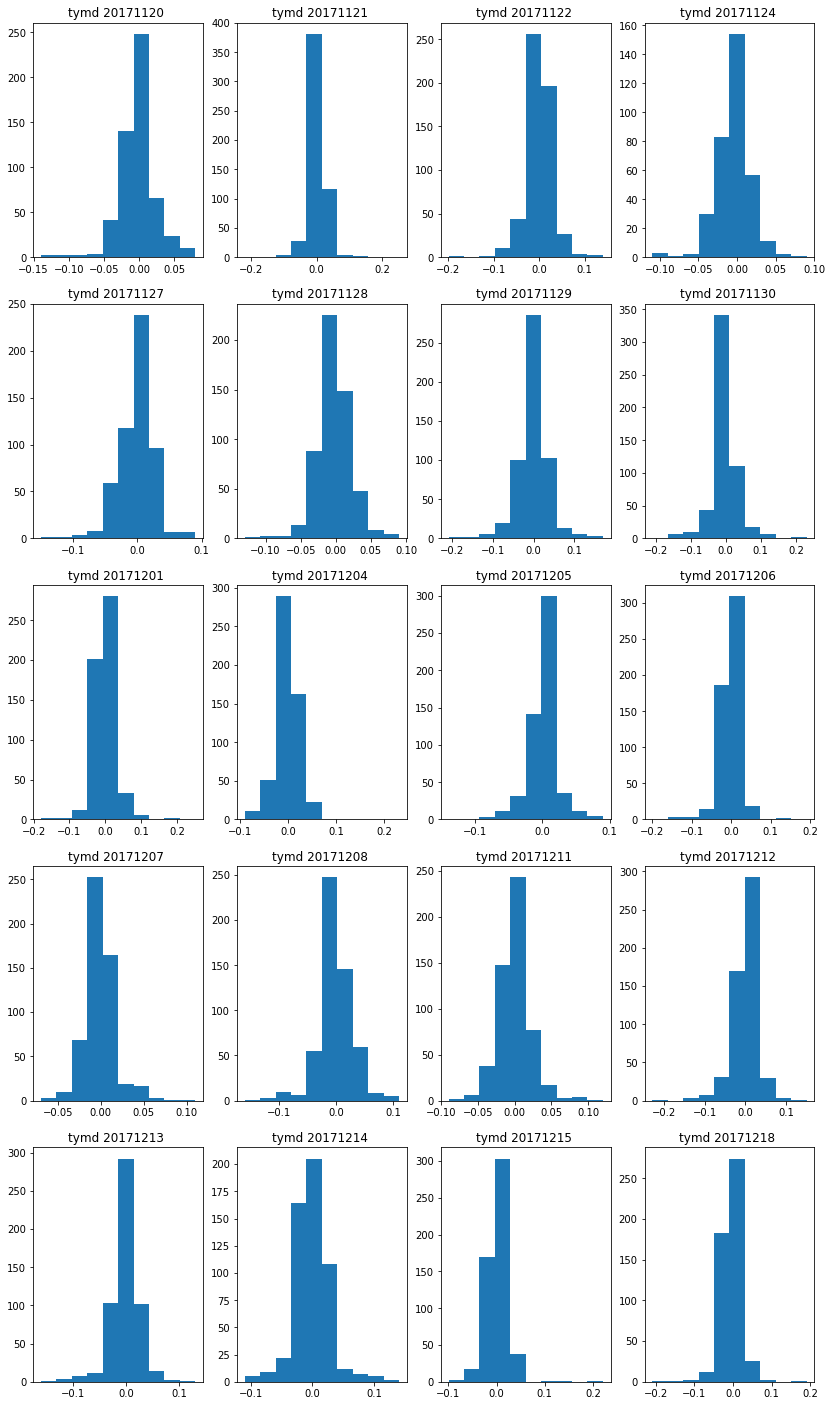

In [138]:
# change these
contract='CLF18'
start_hour=7
end_hour=17
num_graphs_per_row = 4
df3 = df2[df2.symbol==contract]
tymds = df3.apply(lambda r: int('%04d%02d%02d' %(r.tyear,r.tmonth,r.tday)),axis=1).unique()
total_plots= len(tymds)
even_num_tymds = len(tymds)//num_graphs_per_row * num_graphs_per_row
tymds_even_sets = np.array(tymds)[:even_num_tymds]
tymd_sets = np.array(tymds_even_sets).reshape(-1,num_graphs_per_row)
total_figure_length = total_plots//num_graphs_per_row
# plt.figure(1,figsize=(12*5,5*total_figure_length))
fig, axes = plt.subplots(nrows=even_num_tymds//num_graphs_per_row,ncols=num_graphs_per_row,figsize=(14,5*total_figure_length))
for row in range(len(tymd_sets)):
    tymd_set = tymd_sets[row]
    for col in range(len(tymd_set)):
        tymd = tymd_set[col]
        y = int(str(tymd)[0:4])
        m = int(str(tymd)[4:6])
        d = int(str(tymd)[6:8])
        df_1d = df3[(df3.tyear==y) & (df3.tmonth==m)&(df3.tday==d)]
#         plt.subplot(total_plots//num_graphs_per_row,num_graphs_per_row,plot_num,title=f'tymd {tymd}')
        df_1d = df3[(df3.year==y) & (df3.month==m) & (df3.day==d) & (df3.hour>=start_hour) & (df3.hour<end_hour)]
        y = np.array(df_1d.close.pct_change()*df_1d.close)[1:]
        axes[row,col].hist(y)
        axes[row,col].set_title(f'tymd {tymd} ')
plt.show()

Create Daily candles for the month of trades in df3

201804010000


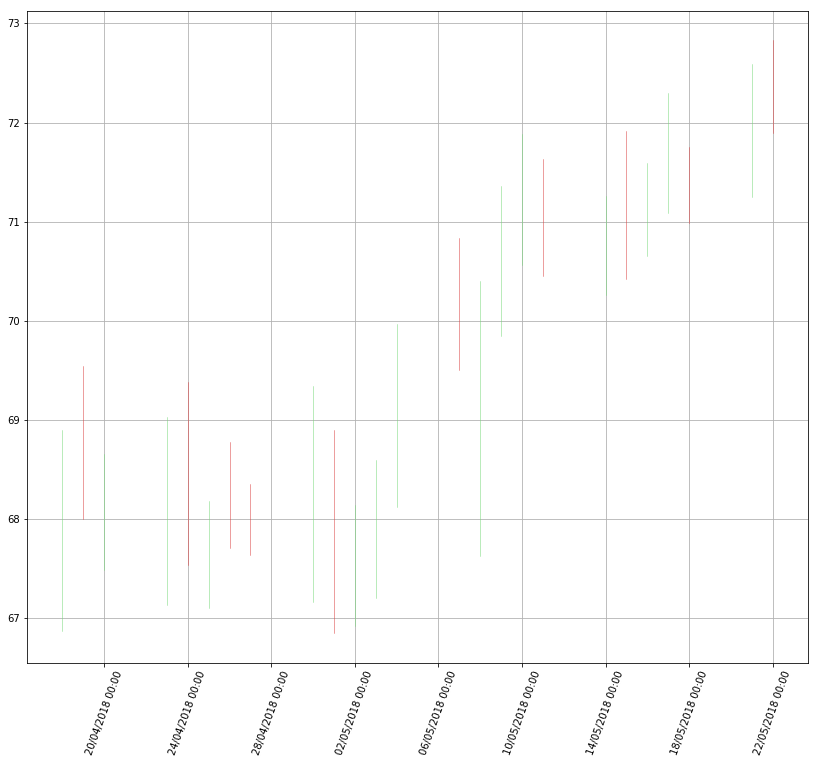

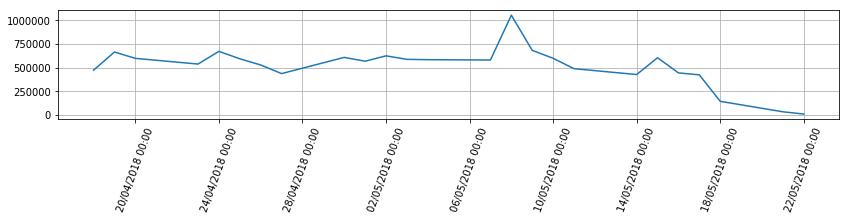

In [65]:
index_cols = ['tyear','tmonth','tday','dte']
price_cols = ['open','high','low','close','volume']
df3_daily = df3[index_cols + price_cols].groupby(index_cols,as_index=False).agg({'open':'mean','high':'max','low':'min','close':'mean','volume':'sum'})
df3_daily['yyyymmddhhmm'] = df3_daily.apply(lambda r: int('%04d%02d%02d0000' %(r.tyear,r.tmonth,r.tday)),axis=1)
df3_daily['year'] = df3_daily.tyear.astype(int)
df3_daily['month'] = df3_daily.tmonth.astype(int)
df3_daily['day'] = df3_daily.tday.astype(int)
df3_daily['hour'] = int('0')
df3_daily['minute'] = int('0')
df3_daily.head()
futs.plot_candles(dfcv=df3_daily)


In [132]:
#scale bars
scale_factor=15
df_scaled = futs.scale_df(df_minute_data=df2,scale_factor=scale_factor)
df_scaled.tail(100)

,cyear,cmonth,symbol,year,month,day,hour,minute,tyear,tmonth,tday,yyyymmddhhmm,close,high,low,open,volume,last_yyyymmddhhmm,dte
271921,2018,12,CLZ18,2018,11,16,10,45,2018,11,16,201811161045,56.838000,56.95,56.73,56.834000,1059,201811191329,3
271922,2018,12,CLZ18,2018,11,16,11,0,2018,11,16,201811161100,56.808667,56.88,56.73,56.801333,882,201811191329,3
271923,2018,12,CLZ18,2018,11,16,11,15,2018,11,16,201811161115,56.544000,56.82,56.08,56.586667,2016,201811191329,3
271924,2018,12,CLZ18,2018,11,16,11,30,2018,11,16,201811161130,56.356000,56.63,55.89,56.326000,2215,201811191329,3
271925,2018,12,CLZ18,2018,11,16,11,45,2018,11,16,201811161145,56.757333,56.98,56.56,56.740000,1438,201811191329,3
271926,2018,12,CLZ18,2018,11,16,12,0,2018,11,16,201811161200,56.761333,56.93,56.66,56.762000,1085,201811191329,3
271927,2018,12,CLZ18,2018,11,16,12,15,2018,11,16,201811161215,56.673333,56.83,56.45,56.681333,1030,201811191329,3
271928,2018,12,CLZ18,2018,11,16,12,30,2018,11,16,201811161230,56.506667,56.65,56.28,56.508667,1006,201811191329,3
271929,2018,12,CLZ18,2018,11,16,12,45,2018,11,16,201811161245,56.691333,56.79,56.55,56.684667,1011,201811191329,3
271930,2018,12,CLZ18,2018,11,16,13,0,2018,11,16,201811161300,56.498667,56.68,56.42,56.510000,720,201811191329,3


In [74]:
print(df_scaled[(df_scaled.hour==10)&(df_scaled.symbol=='CLM08')].volume.sum())
print(df2[(df2.hour==10)&(df2.symbol=='CLM08')].volume.sum())


3180
3180


get data for USO directly from barchart_api

In [139]:
import barchart_api as bcapi
api_key = open(f'temp_folder/paid_api_key.txt','r').read()
ep = bcapi.BcHist.endpoints['paid_url']

In [140]:
bc = bcapi.BcHist(api_key=api_key,endpoint_type='paid_url')

Barchart OnDemand Client: http://ondemand.websol.barchart.com/


In [145]:
# df_uso = bc.get_history('uso',beg_yyyymmdd=20080101,end_yyyymmdd=20181231)

In [146]:
df_uso = df_uso[1]


In [156]:
df_uso.head()

,close,high,low,open,symbol,timestamp,tradingDay,volume
0,95.17,95.23,95.11,95.23,uso,2008-05-05T09:30:00-04:00,2008-05-05,36700
1,95.23,95.25,95.13,95.16,uso,2008-05-05T09:31:00-04:00,2008-05-05,109500
2,95.29,95.36,95.20,95.22,uso,2008-05-05T09:32:00-04:00,2008-05-05,66400
3,95.35,95.48,95.28,95.29,uso,2008-05-05T09:33:00-04:00,2008-05-05,87600
4,95.39,95.43,95.31,95.35,uso,2008-05-05T09:34:00-04:00,2008-05-05,62300


In [150]:
df_uso.to_csv(f'{DIR_STOCKS}/uso.csv',index=False)

In [155]:
len(df_uso),len(df2[(df2.hour>=9) & (df2.hour<=16)])


(1030372, 1224763)

In [179]:
df_uso2 = futs.proc_df(df=df_uso,is_commodity=False)

In [180]:
df_uso2.as_matrix().shape

(1030372, 19)

In [181]:
df_uso2.head()

,cyear,cmonth,symbol,year,month,day,hour,minute,tyear,tmonth,tday,yyyymmddhhmm,close,high,low,open,volume,last_yyyymmddhhmm,dte
0,2008,5,uso,2008,5,5,9,30,2008,5,5,200805050930,95.17,95.23,95.11,95.23,36700,201812181159,3879
1,2008,5,uso,2008,5,5,9,31,2008,5,5,200805050931,95.23,95.25,95.13,95.16,109500,201812181159,3879
2,2008,5,uso,2008,5,5,9,32,2008,5,5,200805050932,95.29,95.36,95.20,95.22,66400,201812181159,3879
3,2008,5,uso,2008,5,5,9,33,2008,5,5,200805050933,95.35,95.48,95.28,95.29,87600,201812181159,3879
4,2008,5,uso,2008,5,5,9,34,2008,5,5,200805050934,95.39,95.43,95.31,95.35,62300,201812181159,3879
